# M1 Coursework

Yuanzhen Zhao (yz929)

## Question 1

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import optuna

from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Input, Dropout
from tensorflow.keras.utils import to_categorical, plot_model

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE

c:\Users\JZ\anaconda3\envs\dis_m1_coursework\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
batch_size = 128
num_classes = 19
epochs = 20

(x_train, y_train), (x_test, y_test) = mnist.load_data()
assert x_train.shape == (60000, 28, 28)
assert x_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [3]:
images = np.concatenate((x_train, x_test), axis=0)
labels = np.concatenate((y_train, y_test), axis=0)

In [ ]:
def create_combined_images(images, labels, dataset_size=10000, seed = 42):
    """Create a set of combined 56x28x1 images and labels."""
    np.random.seed(seed)
    combined_images = []
    combined_labels = []
    
    for _ in range(dataset_size):
        idx1, idx2 = np.random.choice(np.arange(len(images)), 2, replace=True)
        img1, img2 = images[idx1], images[idx2]
        label1, label2 = labels[idx1], labels[idx2]
        
        combined_image = np.hstack((img1, img2))
        combined_label = label1 + label2
        
        combined_images.append(combined_image)
        combined_labels.append(combined_label)
        
    combined_images = np.array(combined_images).reshape(-1, 28, 56, 1)
    combined_labels = np.array(combined_labels)
    
    return combined_images, combined_labels

In [5]:
def generate_dataset(images, labels, dataset_size, num_classes = 10, label_one_hot = False, seed = 42):
    """Generate a train, validation & test dataset of 28x28 images and labels."""
    np.random.seed(seed)
    train_size = int(0.6 * dataset_size)
    val_size = int(0.2 * dataset_size)
    # test_size = dataset_size - train_size - val_size
    
    image_samples = []
    label_samples = []
    
    for _ in range(dataset_size):
        idx = np.random.choice(np.arange(len(images)))
        img = images[idx]
        label = labels[idx]
        image_samples.append(img)
        label_samples.append(label)
        
    images = np.array(image_samples).reshape(-1, 28, 28, 1)
    labels = np.array(label_samples)
        
    train_images, train_labels = images[:train_size], labels[:train_size]
    val_images, val_labels = images[train_size:train_size+val_size], labels[train_size:train_size+val_size]
    test_images, test_labels = images[train_size+val_size:], labels[train_size+val_size:]
    
    if label_one_hot:
        train_labels = to_categorical(train_labels, num_classes)
        val_labels = to_categorical(val_labels, num_classes)
        test_labels = to_categorical(test_labels, num_classes)
        
    print("Train 28x28 images shape: ", train_images.shape)
    print("Validation 28x28 images shape: ", val_images.shape)
    print("Test 28x28 images shape: ", test_images.shape)
        
    return (train_images, train_labels), (val_images, val_labels), (test_images, test_labels)    

In [ ]:
def generate_combined_dataset(images, labels, dataset_size, num_classes = 19, label_one_hot = False):
    """Generate a train, validation & test dataset of 56x28 images and labels."""
    train_size = int(0.6 * dataset_size)
    val_size = int(0.2 * dataset_size)
    # test_size = dataset_size - train_size - val_size
    
    combined_images, combined_labels = create_combined_images(images, labels, dataset_size)
    
    train_images, train_labels = combined_images[:train_size], combined_labels[:train_size]
    val_images, val_labels = combined_images[train_size:train_size+val_size], combined_labels[train_size:train_size+val_size]
    test_images, test_labels = combined_images[train_size+val_size:], combined_labels[train_size+val_size:]
    
    if label_one_hot:
        train_labels = to_categorical(train_labels, num_classes)
        val_labels = to_categorical(val_labels, num_classes)
        test_labels = to_categorical(test_labels, num_classes)
        
    print("Train 56x28 images shape: ", train_images.shape)
    print("Validation 56x28 images shape: ", val_images.shape)
    print("Test 56x28 shape: ", test_images.shape)
        
    return (train_images, train_labels), (val_images, val_labels), (test_images, test_labels)

In [7]:
# Generate dataset of combined images
(train_images, train_labels), (val_images, val_labels), (test_images, test_labels) = generate_combined_dataset(images, labels, dataset_size=100000, label_one_hot=True)

Train 56x28 images shape:  (60000, 28, 56, 1)
Validation 56x28 images shape:  (20000, 28, 56, 1)
Test 56x28 shape:  (20000, 28, 56, 1)


## Question 2

In [8]:
np.random.seed(42)

In [9]:
def objective(trial):
    # Suggest values for hyperparameters
    num_units_layer1 = trial.suggest_int("units_layer1", 256, 512, step=32)
    num_units_layer2 = trial.suggest_int("units_layer2", 256, 512, step=32)
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5, step=0.1)
    learning_rate = trial.suggest_float("learning_rate", 1e-3, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [128, 256, 512])

    # Build the model
    model = Sequential([
        Input(shape=(28, 56, 1)),
        Flatten(),
        Dense(num_units_layer1, activation='relu'),
        Dropout(dropout_rate),
        Dense(num_units_layer2, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    
    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Train the model
    history = model.fit(
        train_images, train_labels,
        validation_data=(val_images, val_labels),
        epochs=20,  # Use a small number of epochs for tuning
        batch_size=batch_size,
        verbose=0  # Suppress output for faster tuning
    )
    
    # Evaluate the model on validation data
    val_accuracy = history.history['val_accuracy'][-1]  # Last epoch's validation accuracy
    return -val_accuracy


In [10]:
study = optuna.create_study(direction="minimize", load_if_exists=True)
study.optimize(objective, n_trials=5)  # Run 30 trials

best_params = study.best_params
best_accuracy = -study.best_value  # Negate the value to get accuracy
print(f"Best parameters: {best_params}")
print(f"Best validation accuracy: {best_accuracy:.4f}")

[I 2024-12-10 22:39:05,416] A new study created in memory with name: no-name-41f77cd8-e57e-43c7-89c0-eb99236a61a4
[I 2024-12-10 22:39:21,504] Trial 0 finished with value: -0.9112499952316284 and parameters: {'units_layer1': 480, 'units_layer2': 448, 'dropout_rate': 0.1, 'learning_rate': 0.003343001043317202, 'batch_size': 512}. Best is trial 0 with value: -0.9112499952316284.
[I 2024-12-10 22:41:11,123] Trial 1 finished with value: -0.8880500197410583 and parameters: {'units_layer1': 320, 'units_layer2': 512, 'dropout_rate': 0.4, 'learning_rate': 0.0037850952240923216, 'batch_size': 128}. Best is trial 0 with value: -0.9112499952316284.
[I 2024-12-10 22:41:31,759] Trial 2 finished with value: -0.9204000234603882 and parameters: {'units_layer1': 448, 'units_layer2': 288, 'dropout_rate': 0.5, 'learning_rate': 0.0027056502561345576, 'batch_size': 256}. Best is trial 2 with value: -0.9204000234603882.
[I 2024-12-10 22:41:56,554] Trial 3 finished with value: -0.9244499802589417 and paramete

Best parameters: {'units_layer1': 480, 'units_layer2': 448, 'dropout_rate': 0.2, 'learning_rate': 0.0017624068432057533, 'batch_size': 512}
Best validation accuracy: 0.9244


In [11]:
# Build the best model with the optimized parameters
best_model = Sequential([
    Input(shape=(28, 56, 1)),
    Flatten(),
    Dense(best_params['units_layer1'], activation='relu'),
    Dropout(best_params['dropout_rate']),
    Dense(best_params['units_layer2'], activation='relu'),
    Dense(num_classes, activation='softmax')
])

In [12]:
best_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=best_params['learning_rate']),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the best model on the full training set
best_model.fit(
    train_images, train_labels,
    validation_data=(val_images, val_labels),
    epochs=20,
    batch_size=best_params['batch_size']
)

test_predictions = best_model.predict(test_images).argmax(axis=1)

test_accuracy = accuracy_score(test_labels.argmax(axis=1), test_predictions)

print(f"Test accuracy: {test_accuracy:.4f}")

Epoch 1/20


118/118 [==============================] - 2s 16ms/step - loss: 1.6228 - accuracy: 0.4713 - val_loss: 0.8623 - val_accuracy: 0.7379
Epoch 2/20
118/118 [==============================] - 2s 18ms/step - loss: 0.7474 - accuracy: 0.7692 - val_loss: 0.6060 - val_accuracy: 0.8172
Epoch 3/20
118/118 [==============================] - 2s 16ms/step - loss: 0.5271 - accuracy: 0.8390 - val_loss: 0.5133 - val_accuracy: 0.8472
Epoch 4/20
118/118 [==============================] - 2s 14ms/step - loss: 0.4077 - accuracy: 0.8753 - val_loss: 0.4386 - val_accuracy: 0.8691
Epoch 5/20
118/118 [==============================] - 2s 15ms/step - loss: 0.3247 - accuracy: 0.8990 - val_loss: 0.4020 - val_accuracy: 0.8837
Epoch 6/20
118/118 [==============================] - 2s 15ms/step - loss: 0.2635 - accuracy: 0.9190 - val_loss: 0.3688 - val_accuracy: 0.8935
Epoch 7/20
118/118 [==============================] - 2s 15ms/step - loss: 0.2165 - accuracy: 0.9319 - val_loss: 0.3524 - val_accuracy: 0.8985
Epoch 8/20

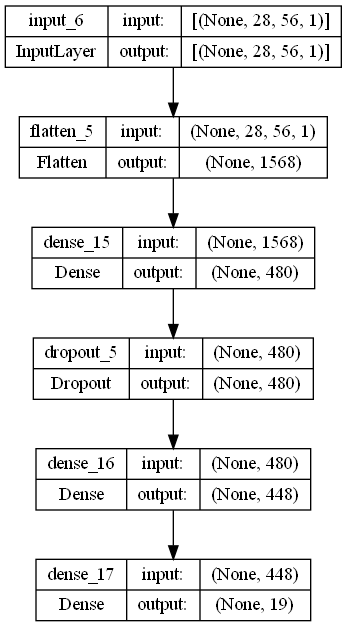

In [13]:
# Save the weights and architecture of the best model
best_model.save_weights('my_best_model.weights.h5')
plot_model(best_model, to_file='model.png', show_shapes=True, show_layer_names=True)

## Question 3

In [29]:
# A smaller dataset for unsupervised learning

(train_images, train_labels), (val_images, val_labels), (test_images, test_labels) = generate_combined_dataset(images, labels, 50000, label_one_hot=False)

# Flatten the images
train_images_flat = train_images.reshape(train_images.shape[0], -1)
test_images_flat = test_images.reshape(test_images.shape[0], -1)

Train 56x28 images shape:  (30000, 28, 56, 1)
Validation 56x28 images shape:  (10000, 28, 56, 1)
Test 56x28 shape:  (10000, 28, 56, 1)


In [30]:
# Random Forest Classifier
# This cell takes around 3 mins to run

RndFrstClass = RandomForestClassifier(n_estimators=500, max_depth=30)
RndFrstClass.fit(train_images_flat, train_labels)
RndFrstPred = RndFrstClass.predict(test_images_flat)

RFC_model_accuracy = accuracy_score(test_labels, RndFrstPred)
print(f"Accuracy of Random Forest Classifier: {RFC_model_accuracy}")

Accuracy of Random Forest Classifier: 0.734


In [31]:
# Support Vector Classifier

svcClass = SVC()
svcClass.fit(train_images_flat, train_labels) 
svcPred = svcClass.predict(test_images_flat)

SVC_model_accuracy = accuracy_score(test_labels, svcPred)
print(f"Accuracy of Support Vector Classifier: {SVC_model_accuracy}")

Accuracy of Support Vector Classifier: 0.7081


## Question 4

In [18]:
# Single layer perceptron as weak linear classifier

def one_image_model(X_train, y_train, X_test, y_test):
    model = Sequential([Input(shape=(28, 56, 1)), Flatten(), Dense(19, activation='softmax')])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=25, batch_size=128, verbose=0)
    
    prediction = model.predict(X_test)
    y_test_predicted = np.argmax(prediction, axis=1)
    y_test = np.argmax(y_test, axis=1)
    test_accuracy = accuracy_score(y_test, y_test_predicted)
    
    return test_accuracy

def two_images_model(X_train, y_train, X_test_first, y_test_first, X_test_second, y_test_second):    
    model = Sequential([Input(shape=(28, 28, 1)), Flatten(), Dense(10, activation='softmax')])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=25, batch_size=128, verbose=0)
    prediction1 = model.predict(X_test_first)
    y_test_first_predicted = np.argmax(prediction1, axis=1)
    y_test_first = np.argmax(y_test_first, axis=1)
    prediction2 = model.predict(X_test_second)
    y_test_second_predicted = np.argmax(prediction2, axis=1)
    y_test_second = np.argmax(y_test_second, axis=1)
    
    test_accuracy = accuracy_score(y_test_first + y_test_second, y_test_first_predicted + y_test_second_predicted)
    
    return test_accuracy

In [19]:
print("ONE IMAGE")
(train_images, train_labels), (val_images, val_labels), (test_images, test_labels) = generate_combined_dataset(images, labels, 12000, label_one_hot=True)
print("\nTWO IMAGES")
(train_separate_images, train_separate_labels), (val_separate_images, val_separate_labels), (test_separate_images, test_separate_labels) = generate_dataset(images, labels, 12000, label_one_hot=True)

ONE IMAGE
Train 56x28 images shape:  (7200, 28, 56, 1)
Validation 56x28 images shape:  (2400, 28, 56, 1)
Test 56x28 shape:  (2400, 28, 56, 1)

TWO IMAGES
Train 28x28 images shape:  (7200, 28, 28, 1)
Validation 28x28 images shape:  (2400, 28, 28, 1)
Test 28x28 images shape:  (2400, 28, 28, 1)


In [20]:
sample_sizes = [50, 100, 500, 1000]
results_single = []
results_two = []

In [21]:
for size in sample_sizes:
    # Sample a subset for training
    train_images_subset, train_labels_subset = train_images[:size], train_labels[:size]
    
    # Method 1: Classify on a single 56x28 image
    acc_single = one_image_model(train_images_subset, train_labels_subset, test_images, test_labels)
    results_single.append((size, acc_single))
    
    test_images_first, test_labels_first = test_separate_images[:size], test_separate_labels[:size]
    test_images_second, test_labels_second = test_separate_images[size:2*size], test_separate_labels[size:2*size]
        
    # Method 2: Classify on two separate 28x28 images
    acc_two = two_images_model(train_separate_images, train_separate_labels, test_images_first, test_labels_first, test_images_second, test_labels_second)
    results_two.append((size, acc_two))

32/32 [==============================] - 0s 577us/step


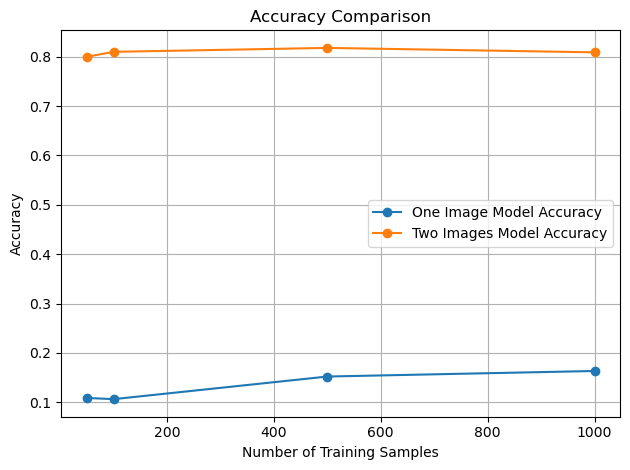

In [22]:
# Visualise results
results_single = np.array(results_single)
results_two = np.array(results_two)

plt.figure()

plt.plot(results_single[:, 0], results_single[:, 1], label="One Image Model Accuracy", marker='o')
plt.plot(results_two[:, 0], results_two[:, 1], label="Two Images Model Accuracy", marker='o')
plt.xlabel("Number of Training Samples")
plt.ylabel("Accuracy")
plt.title("Accuracy Comparison")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

## Question 5

t-SNE distribution of embedding layer

In [23]:
# Re-generate the same combined dataset as optuna optimised with (label not one-hot encoded)
(train_images, train_labels), (val_images, val_labels), (test_images, test_labels) = generate_combined_dataset(images, labels, dataset_size=100000, label_one_hot=False)

Train 56x28 images shape:  (60000, 28, 56, 1)
Validation 56x28 images shape:  (20000, 28, 56, 1)
Test 56x28 shape:  (20000, 28, 56, 1)


In [24]:
embedding_model = Model(inputs=best_model.layers[0].input, outputs=best_model.layers[-2].output)
embedding_output = embedding_model.predict(test_images)

tsne = TSNE(n_components=2, perplexity=20, random_state=42)
reduced_embeddings = tsne.fit_transform(embedding_output)

625/625 [==============================] - 1s 2ms/step


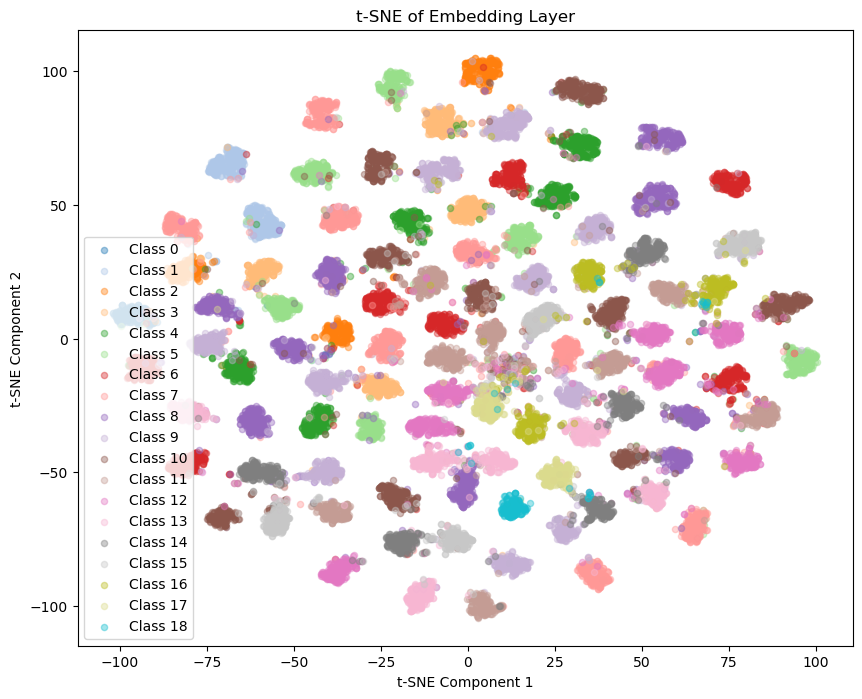

In [25]:
# Manually set the colors for each class as default `tab10` only has 10 colors
cmap = plt.get_cmap('tab20')
colors = [cmap(i) for i in range(num_classes)]

plt.figure(figsize=(10, 8))
for i in range(num_classes):
    idx = np.where(test_labels == i)
    length = len(reduced_embeddings[idx, 0])
    plt.scatter(reduced_embeddings[idx, 0], reduced_embeddings[idx, 1], label=f"Class {i}", alpha=0.4, color=colors[i], s=20)

plt.title("t-SNE of Embedding Layer")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend()
plt.show()

t-SNE distribution on the input dataset

In [26]:
test_images_flat = test_images.reshape(test_images.shape[0], -1)
tsne_input = TSNE(n_components=2, perplexity=20, random_state=42)
test_images_embedded = tsne_input.fit_transform(test_images_flat)

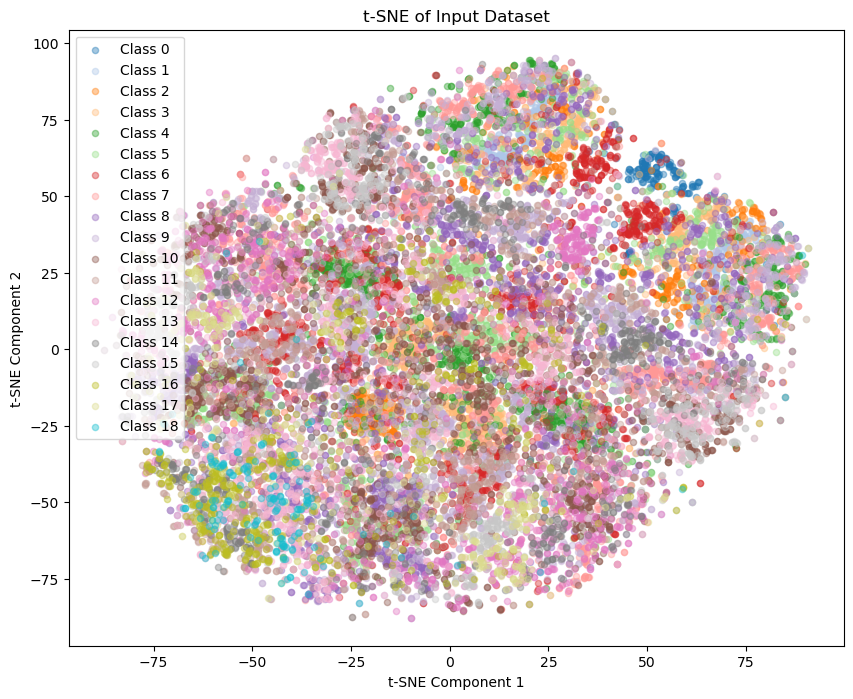

In [27]:
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    idx = np.where(test_labels == i)
    plt.scatter(test_images_embedded[idx, 0], test_images_embedded[idx, 1], label=f"Class {i}", alpha=0.4, color=colors[i], s=20)

plt.title("t-SNE of Input Dataset")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend()
plt.show()